In [87]:
import os, sys
import pandas as pd
import numpy as np
from scipy import interp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import xgboost as xg
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

seed = 26

In [116]:
root = 'wget_data/Demand/'
filenames = []

for path, subdirs, files in os.walk(root):
    for name in files:
        filenames.append(os.path.join(path, name))

print('Reading demand csvs to dataframe...')    
demand_data = pd.concat( [ pd.read_csv(f,skiprows=3) for f in filenames ] )
print('Done.')

Reading demand csvs to dataframe...
Done.


In [117]:
root = 'wget_data/Weather/'
filenames = []

for path, subdirs, files in os.walk(root):
    for name in files:
        filenames.append(os.path.join(path, name))

print('Reading weather csvs to dataframe...')    
weather_data = pd.concat( [ pd.read_csv(f,skiprows=15) for f in filenames ] )
print('Done.')

Reading weather csvs to dataframe...
Done.


In [118]:
demand_data.head()

,Date,Hour,Market Demand,Ontario Demand
0,2016-01-01,1,16767,13417
1,2016-01-01,2,16751,12968
2,2016-01-01,3,16319,12395
3,2016-01-01,4,16148,12228
4,2016-01-01,5,16054,12116


In [119]:
weather_data.head()

,Date/Time,Year,Month,Day,Time,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,Rel Hum (%),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,2016-01-01 00:00,2016,1,1,00:00,0.8,NaN,-4.3,NaN,69.0,...,M,NaN,NaN,100.38,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 01:00,2016,1,1,01:00,0.6,NaN,-4.6,NaN,68.0,...,M,NaN,NaN,100.35,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01 02:00,2016,1,1,02:00,0.5,NaN,-4.0,NaN,72.0,...,M,NaN,NaN,100.30,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01 03:00,2016,1,1,03:00,0.4,NaN,-3.1,NaN,77.0,...,M,NaN,NaN,100.27,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01 04:00,2016,1,1,04:00,0.4,NaN,-3.9,NaN,73.0,...,M,NaN,NaN,100.27,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
print('Cleaning and building training data sets...')
#to datetime
demand_data['Date'] = pd.to_datetime(demand_data['Date']) + pd.to_timedelta(demand_data['Hour'], unit='h')
weather_data['Date/Time'] = pd.to_datetime(weather_data['Date/Time'])

#Merge
weather_data = weather_data.rename(index=str, columns = {"Date/Time":"Date"})
data = demand_data.merge(right=weather_data, how='left', on='Date')
data.drop('Time', axis = 1, inplace = True)

#Feature Creation

#add day of week (Sun-Sat)
data['Day of Week'] = data['Date'].apply(lambda x: x.dayofweek)

#add top five days (add 1 for whole day i.e 24 1's per day or 24*5 1's per year)
data.set_index('Date',drop=False, inplace = True)

top_days = 5

data['topdays'] = 0


for year in range(int(data['Year'].min()),int(data['Year'].max())+1):

    indices = data[data['Year'] == year].resample('D').max().nlargest(top_days,'Ontario Demand').index

    for i in range(len(indices)):
        
        y = data[data.index == indices[i]]['Year'].as_matrix()[0]
        m = data[data.index == indices[i]]['Month'].as_matrix()[0]
        d = data[data.index == indices[i]]['Day'].as_matrix()[0]
        h = data[data.index == indices[i]]['Hour'].as_matrix()[0]
        
        data.loc[data[(data['Year'] == y) & (data['Month'] == m) & (data['Day'] == d) & (data['Hour'] >= h-3) & (data['Hour'] <= h+3)].index, 'topdays'] = 1

#Clean Data
data = data[data.columns[data.isnull().mean() < 0.80]]



Cleaning and building training data sets...


In [126]:
len(data[data['topdays'] == 1])

60

In [127]:
#get target variable
y = data['topdays']
del data['topdays']

#remove unforecastable variables
del data['Year']
del data['Wind Dir Flag']
del data['Wind Spd Flag']

In [128]:
data.reset_index(drop=True, inplace = True)

In [129]:
data.head()

,Date,Hour,Market Demand,Ontario Demand,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Stn Press (kPa),Day of Week
0,2016-01-01 01:00:00,1,16767,13417,1.0,1.0,0.6,-4.6,68.0,100.35,4
1,2016-01-01 02:00:00,2,16751,12968,1.0,1.0,0.5,-4.0,72.0,100.30,4
2,2016-01-01 03:00:00,3,16319,12395,1.0,1.0,0.4,-3.1,77.0,100.27,4
3,2016-01-01 04:00:00,4,16148,12228,1.0,1.0,0.4,-3.9,73.0,100.27,4
4,2016-01-01 05:00:00,5,16054,12116,1.0,1.0,0.2,-4.0,74.0,100.18,4


In [134]:
del data['Date']

In [135]:
X = data

In [136]:
y.reset_index(drop=True, inplace = True)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: topdays, dtype: int64

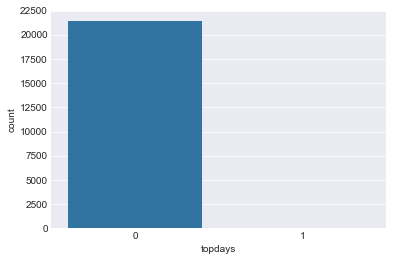

In [132]:
sns.countplot(y)

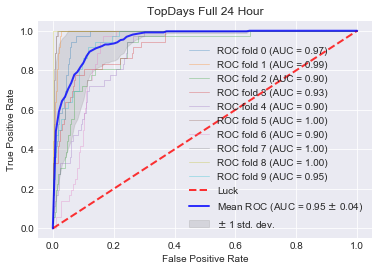

In [109]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves

default_params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.3, 
    'silent': 1.0,
    'scale_pos_weight': float(np.sum(y == 0)) / np.sum(y == 1),
    'n_estimators': 75
}

cv = StratifiedKFold(n_splits=10)
classifier = XGBClassifier(**default_params, seed = seed)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TopDays Full 24 Hour')
plt.legend(loc="lower right")

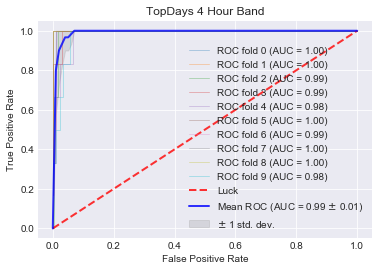

In [137]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves

default_params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.3, 
    'silent': 1.0,
    'scale_pos_weight': float(np.sum(y == 0)) / np.sum(y == 1),
    'n_estimators': 75
}

cv = StratifiedKFold(n_splits=10)
classifier = XGBClassifier(**default_params, seed = seed)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TopDays 4 Hour Band')
plt.legend(loc="lower right")

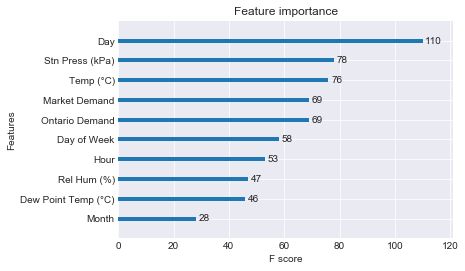

In [138]:
xg.plot_importance(classifier)